<h2>【利用例】不均衡性を解消したTitanicデータの特徴量削減</h2>
<ul>
    <li>Resampled_learn.pyをrslとしてインポート</li>
    <li>生者より死者が多いデータを、生者の数に両方とも合わせる形でリサンプリング</li>
    <li>再帰的特徴量削減により特徴量の数 vs. 精度のグラフ、及び特徴量ごとの重要度グラフを描画</li>
    <li>再帰的特徴量削減により重要度が大きい４変数を抽出</li>
</ul>

Resampled_learnをrslとしてインポート<br>
xgboostをestimatorとして利用<br>

In [77]:
import numpy as np
import pandas as pd
import os
import Resampled_learn as rsl
import xgboost as xgb
import lightgbm as gbm
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import f1_score, log_loss

In [78]:
%%html
<style>
table {float:left}
</style>

データの読み込み<br>
（該当データは本リポジトリにアップしてあります）<br>

In [79]:
os.chdir("C:/Users/zhaow/Dropbox/Datascience/titanic")

In [80]:
df = pd.read_csv('titanic_train_resample.csv', index_col=0)

訓練用、テスト用データの生成<br>

In [81]:
X_ = df.drop('PassengerId', axis=1).drop('Survived', axis=1)
y_ = df['Survived']

In [82]:
X_train, X_test, y_train, y_test = train_test_split(X_, y_, test_size=0.2, stratify=y_)

試しに生者と死者の数をそれぞれ集計<br>

In [83]:
print('Survived: %d ' % y_train.sum())
print('Died: %d' % (len(y_train) - y_train.sum()))

Survived: 273 
Died: 439


生きている人より死んでいる人のほうが多い不均衡データであることがわかる<br>

特徴量を確認<br>

In [84]:
pd.DataFrame(X_train.columns)

,0
0,Age
1,SibSp
2,Parch
3,Fare
4,Sex_dummy
5,Embarked_Q
6,Embarked_C
7,Mrs.
8,Master.
9,Miss.


説明変数＝特徴量は全部で14個ある。

<h2>Class Resampled_Prediction</h2>
<p>データリサンプリング、標準化、予測器へのfitを一度に行いたい場合は、Resampled_Predictionを利用できる。</p>

|パラメータ|意味|
|:------------:|:-------------------------------------------------------------|
| sampler | 使用するimbalanced-learnが提供するリサンプリング関数(RandomUnderSampler, SMOTEなど）、使用しない場合はNone |
| scaler | 使用する標準化関数(StandardScaler)/正規化関数(MinMaxScaler)、使用しない場合はNone |
| estimator | 使用する機械学習モデル |

In [86]:
clf = rsl.Resampled_Prediction(estimator=xgb.XGBClassifier(n_jobs=-1),
                               scaler=rsl.StandardScaler(),
                               sampler=rsl.RandomUnderSampler(ratio='not minority'))

fit(X, y)メソッドの使い方は、その他sklearnベースの予測器と同じ。<br>

In [87]:
clf.fit(X_train, y_train)

predict(X), predict_proba(X), score(X, y)メソッドの使い方も、その他skicit-learnベースの予測器と同じ。<br>

In [88]:
y_pred = clf.predict(X_test)
y_prob = clf.predict_proba(X_test)

In [89]:
print('Accuracy: {:.2%}'.format(clf.score(X_test, y_test)))
print('Precision: {:.2%}'.format(f1_score(y_test, y_pred)))
print('logloss: {:.2}'.format(log_loss(y_test, y_prob)))

Accuracy: 83.24%
Precision: 78.87%
logloss: 0.41


<h2>Class Resampled_Cross_Validation</h2>
<p>データのリサンプリング、標準化、指定予測器で指定した回数だけ交差検証したい場合は、Resampled_Cross_Validationを利用できる。<br>
ここでは。アンダーサンプリング（少ないデータに多い方のデータを落とす、imbalanced-learnライブラリーにあるRandomUnderSamplerを利用）で不均衡を解消して10回クロスバリデーションを行った例を示す。<br></p>

モジュールからResampled_Cross_Validateを呼び出し、パラメータを指定する。<br>

|パラメータ|意味|
|:------------:|:-------------------------------------------------------------|
| cv | クロスバリデーションの回数 |
| sampler | 使用するimbalanced-learnが提供するリサンプリング関数(RandomUnderSampler, SMOTEなど）、使用しない場合はNone |
| scaler | 使用する標準化関数(StandardScaler)/正規化関数(MinMaxScaler)、使用しない場合はNone |
| estimator | 使用する機械学習モデル |
| verbose | 計算ログの表示(Trueで表示、Falseで非表示）|

In [90]:
rfe = rsl.Resampled_Cross_Validate(cv=10,
                                   estimator=xgb.XGBClassifier(n_jobs=-1),
                                   sampler=rsl.SMOTE(kind='regular'),
                                   scaler=rsl.StandardScaler(),
                                   verbose=True
                                  )

In [91]:
rfe.fit(X_train, y_train)

Start Processing Resampled Validation: 10 splits
Done: 1, Totaling: 10
Done: 2, Totaling: 10
Done: 3, Totaling: 10
Done: 4, Totaling: 10
Done: 5, Totaling: 10
Done: 6, Totaling: 10
Done: 7, Totaling: 10
Done: 8, Totaling: 10
Done: 9, Totaling: 10
Done: 10, Totaling: 10


交差検証の各種精度指標を確認<br>

|精度指標|呼び出し方|
|:------:|:------:|
|Accuracy|self.acc_|
|Precision|self.pre_|
|Recall|self.rec_|
|F1|self.f1_|
|ROC_AUC|self.roc_auc_|
|logarithmic loss|self.logloss_|

In [92]:
print('Accuracy: {:.2%}'.format(rfe.acc_.mean()))
print('Precision Score: {:.2%}'.format(rfe.pre_.mean()))
print('Recall Score: {:.2%}'.format(rfe.rec_.mean()))
print('F1 Score: {:.2%}'.format(rfe.f1_.mean()))
print('ROC AUC: {:.2%}'.format(rfe.roc_auc_.mean()))
print('log loss: {:.2}'.format(rfe.logloss_.mean()))

Accuracy: 83.28%
Precision Score: 79.84%
Recall Score: 76.88%
F1 Score: 77.87%
ROC AUC: 82.06%
log loss: 0.41


<h2>Class Resampled_RFECV</h2>
<p>不均衡性を解消し、再帰的特徴量削減によって特徴量削減を行うクラス<br>
ここでは、10回の交差検証で各種精度指標を出力しつつ、合計14の特徴量を1ずつ削減した場合の出力を示す。<br></p>

モジュールからResampled_RFECVを呼び出す<br>

|パラメータ|意味|
|:------------:|:-------------------------------------------------------------|
| cv | クロスバリデーションの回数 |
|n_steps|一度に何個特徴量を削減するか？（全特徴量の数で割り切れる数字である必要がある）|
| sampler | 使用するimbalanced-learnが提供するリサンプリング関数(RandomUnderSampler, SMOTEなど）、使用しない場合はNone |
| scaler | 使用する標準化関数(StandardScaler)/正規化関数(MinMaxScaler)、使用しない場合はNone |
| estimator | 使用する機械学習モデル |
| verbose | 計算ログの表示(Trueで表示、Falseで非表示）|

In [96]:
rfecv = rsl.Resampled_RFECV(cv=10,
                            n_steps=1,
                            estimator=xgb.XGBClassifier(n_jobs=-1),
                            sampler=rsl.SMOTE(kind='regular'),
                            scaler=rsl.StandardScaler(),
                            verbose=False
                           )

指定した削減数だけ、計算する（今回は1つずつ特徴量を削減するので14ステップ計算する）<br>

In [97]:
rfecv.fit(X_train, y_train)

100%|██████████| 14/14 [00:05<00:00,  2.48it/s]


ステップごとの評価指標の平均値は、mean_score_['指定指標']で取得できる。<br>

|精度指標|呼び出し方|
|:------:|:------:|
|Accuracy|self.mean_score_['ACC']|
|Precision|self.mean_score_['PRE']|
|Recall|self.mean_score_['REC']|
|F1|self.mean_score_['F1']|
|ROC_AUC*|self.mean_score_['ROC_AUC']|
|logarithmic loss**|self.mean_score_['logloss']|

<p>*: 2値分類モジュールのみで使用可能<br>
**: 多クラス分類モジュールのみで使用可能<br></p>

In [98]:
rfecv.mean_score_['ACC']

array([0.6613738 , 0.65855466, 0.6937486 , 0.81889057, 0.81750112,
       0.81466577, 0.83567572, 0.83141013, 0.82579533, 0.82861279,
       0.82863291, 0.8300218 , 0.83137044, 0.82724402])

ステップごとの評価指標の分散は、std_score_['指定指標']で取得できる。<br>

In [99]:
rfecv.std_score_['ACC']

array([0.0538732 , 0.03280662, 0.04348615, 0.02066495, 0.03558821,
       0.03336837, 0.03428076, 0.0315021 , 0.02391672, 0.02878932,
       0.03248408, 0.02984197, 0.03533038, 0.03136007])

特徴量の数 vs. 精度指標のグラフの描画は、draw_figureメソッドで可能。<br>

|パラメータ|意味|
|:------:|:------:|
|X|説明変数の行列|
|y|被説明変数のベクトル|
|ymin|グラフ縦軸の最小値|
|ymax|グラフ縦軸の最大値|
|fill_btw|True:影で分散を表示 False:非表示|

<Figure size 432x288 with 0 Axes>

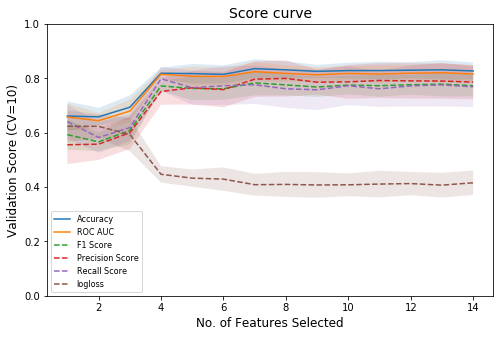

In [100]:
rfecv.draw_figure(X_train, y_train, ymin=0.0, ymax=1.0, fill_btw=True)

基本、特徴量を削減すればするほど精度は落ちるが、重要度が低い特徴量から落としているので、特徴量が多いうちは精度があまり変わらない。<br>
すなわち、最初のうちに削減する特徴量は予測精度に大きく寄与しないことがわかる。<br>
逆に、最後の方に削減する特徴量は予測精度に大きく寄与する重要な特徴量なので、精度の落ち込みが大きい。<br>
このグラフを見ながら精度ロスを抑えながら必要のない特徴量を削減することが可能。<br>
今回は5つの特徴量でそこそこ精度が出ていることがわかる。<br>

特徴量を重要度順に描画したいときは、draw_barchartを利用できる。<br>

<Figure size 432x288 with 0 Axes>

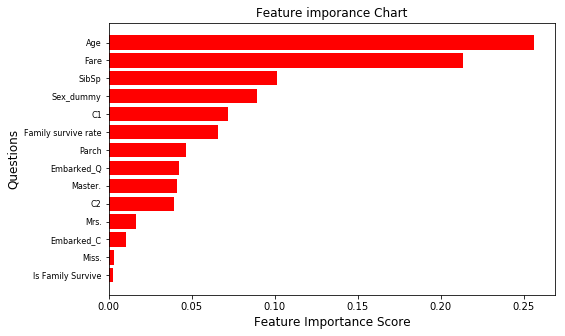

In [101]:
rfecv.draw_barchart(X_train, y_train)

Titanicの生死を分ける重要な変数上位5つは：
<ul>
    <li>Age（年齢）</li>
    <li>Fare（運賃）</li>
    <li>SibSp（乗船していた兄弟もしくは配偶者の数）</li>
    <li>Sex Dummy（性別のダミー）</li>
    <li>Family Survive Rate（家族の生存率）</li>
</ul>
で有ることがわかる。<br>

<h2>Class Resampled_RFE</h2>
<p>不均衡性を解消しつつ、指定した特徴量の数まで再帰的特徴量削減を行いたい場合は、Resampled_RFEを利用する。<br>
再帰的特徴量削減により、指定した数＝5つまで特徴量を落としてみる。<br></p>

|パラメータ|意味|
|:------------:|:-------------------------------------------------------------|
| cv | クロスバリデーションの回数 |
|n_feature_select|何個まで特徴量を残すか？|
|n_steps|一度に何個特徴量を削減するか？（全特徴量の数で割り切れる数字である必要がある）|
| sampler | 使用するimbalanced-learnが提供するリサンプリング関数(RandomUnderSampler, SMOTEなど）、使用しない場合はNone |
| scaler | 使用する標準化関数(StandardScaler)/正規化関数(MinMaxScaler)、使用しない場合はNone |
| estimator | 使用する機械学習モデル |
| verbose | 計算ログの表示(Trueで表示、Falseで非表示）|

In [102]:
rfe = rsl.Resampled_RFE(cv=10,
                        n_feature_select=5,
                        n_steps=1,
                        sampler=rsl.SMOTE(kind='regular'),
                        scaler=rsl.StandardScaler(),
                        estimator=xgb.XGBClassifier(n_jobs=-1)
                       )

In [103]:
rfe.fit(X_train, y_train)

100%|██████████| 9/9 [00:03<00:00,  2.27it/s]


選択された特徴量を確認は。support()メソッドを使用。<br>

In [104]:
rfe.support()

,Var,Support
0,Age,True
1,SibSp,True
2,Parch,False
3,Fare,True
4,Sex_dummy,True
5,Embarked_Q,False
6,Embarked_C,False
7,Mrs.,False
8,Master.,False
9,Miss.,False


必要な特徴量が選択されたことがわかる。<br>